# Gosai et al. Human MPRA Dataset

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import wandb
import tempfile
import pandas as pd
import torch
import sys
sys.path.append("../../")
%matplotlib inline

# wandb.login(host = "https://genentech.wandb.io" )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import datetime
unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")

run_name = "Regression_EnformerPretrained_k562"
run_name += f"_{unique_id}"

# run = wandb.init(project="RL-conditioning-DNA_oracles", name=run_name)

# run = wandb.init(entity='zhao-yulai', project='human-mpra-gosai-2023', job_type='training', name='train')
# run.name

## 1- Prepare the data

***

In [8]:
# Check Data 
datafile = pd.read_csv("artifacts/DNA-dataset:v0/dataset.csv.gz")
datafile.head()

,Unnamed: 0,chrom,seq,hepg2,k562,sknsh
0,0,chr7,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,0.233601,0.060779,0.047194
1,1,chr1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,0.004565,0.379639,-0.244395
2,2,chr1,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,0.384537,0.036707,-0.004578
3,3,chr15,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,4.116494,4.508784,3.040183
4,4,chr12,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,1.423444,1.616602,1.335892


In [9]:
cell_lines = datafile[['hepg2', 'k562', 'sknsh']]

# Compute the correlation matrix
correlation_matrix = cell_lines.corr()

# Display the correlation matrix
print("Correlation between cell lines:")
print(correlation_matrix)

Correlation between cell lines:
          hepg2      k562     sknsh
hepg2  1.000000  0.805717  0.842394
k562   0.805717  1.000000  0.764004
sknsh  0.842394  0.764004  1.000000


In [10]:
# Select data 
oracle_data = datafile.loc[
    (datafile['chrom'] =="chr15") | 
    (datafile['chrom'] =="chr16") |
    (datafile['chrom'] =="chr17") |
    (datafile['chrom'] =="chr18") |
    (datafile['chrom'] =="chr19") |
    (datafile['chrom'] =="chr20") |
    (datafile['chrom'] =="chr21") |
    (datafile['chrom'] =="chr22") ]

## 2- Model training

### Load the dataset

### Train/Val/Test split by chromosome

In [11]:
import grelu.data.preprocess

train_chroms = None
val_chroms   = ['chr18']
test_chroms  = ['chr21']

df_train, df_val, df_test = grelu.data.preprocess.split(
    oracle_data, 
    train_chroms=train_chroms,
    val_chroms=val_chroms,
    test_chroms=test_chroms,
)

df_train = df_train[['seq', 'k562']]
df_val = df_val[['seq', 'k562']]

Selecting training samples
Keeping 175387 intervals


Selecting validation samples
Keeping 15502 intervals


Selecting test samples
Keeping 10288 intervals
Final sizes: train: (175387, 6), val: (15502, 6), test: (10288, 6)


In [12]:
print(df_train.head())

# num_pos = (df_train['k562'] == 1).sum()
# num_neg = (df_train['k562'] == 0).sum()

                                                  seq      k562
3   CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...  4.508784
27  CATAAAGAAAGTTATACATTCTATTTTTATTCTTTTTATAGGTCCT... -0.020888
28  CATAAAGAAGTTGGTTTTGTTTGCATACCACTGATTTTTAAAACTC...  0.367932
29  CATAAAGAAGTTGGTTTTGTTTGCATACCACTGATTTTTAAAACTC...  0.313411
36  CATAACACTAACTCTGACCCCTCTCACGAGCATCAGGCCTGCAGAT...  0.217126


### Start the training!

In [13]:
model_params = {
    'model_type':'EnformerPretrainedModel',
    'n_tasks': 1,
    'n_transformers': 3,
}

train_params = {
    'task':'regression',
    'loss': 'MSE',
    'lr':1e-4,
    'logger': 'wandb',
    'batch_size': 512,
    'num_workers': 4,
    'devices': [1],
    'save_dir': 'experiment',
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True,
}

In [18]:

import grelu.data.dataset
from grelu.lightning import LightningModel

train_dataset = grelu.data.dataset.DFSeqDataset(df_train)
val_dataset   = grelu.data.dataset.DFSeqDataset(df_val)

model = LightningModel(model_params=model_params, train_params=train_params)

Sequences will be extracted from columns ['seq']
Sequences will be extracted from columns ['seq']


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


In [19]:
# Train model
trainer = model.train_on_dataset(train_dataset, val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Validation DataLoader 0: 100%|██████████| 31/31 [00:02<00:00, 15.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.3628041744232178
         val_mse             1.338426947593689
       val_pearson          0.2168678492307663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 103 M  | train
1 | loss         | MSELoss                 | 0      | train
2 | activation   | Identity                | 0      | train
3 | val_metrics  | MetricCollection        | 0      | train
4 | test_metrics | MetricCollection        | 0      | train
5 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
103 M     Trainable params
0         Non-trainable params
103 M     Total params
412.506   Total estimated model params size (MB)


/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch 9: 100%|██████████| 343/343 [00:48<00:00,  7.13it/s, v_num=qflq, train_loss_step=0.165, train_loss_epoch=0.172]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 343/343 [00:50<00:00,  6.83it/s, v_num=qflq, train_loss_step=0.165, train_loss_epoch=0.172]


### Save the model

In [20]:
# artifact = wandb.Artifact('model', type='model')

# artifact.add_file(trainer.checkpoint_callback.best_model_path, 'k562_2class_model.ckpt')
# run.log_artifact(artifact)

In [21]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▅▄▃▃▂▂▂▁▁
train_loss_step,▇█▆▇▄▅▄▄▄▄▄▃▃▃▄▂▃▂▃▃▃▂▂▃▂▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,█▂▁▁▁▁▁▁▁▁▁
val_mse,█▂▁▁▁▁▁▁▁▁▁
val_pearson,▁▇█████████
epoch,9
train_loss_epoch,0.17246
train_loss_step,0.1568
trainer/global_step,3429


***

## 3- Test model

In [22]:
trainer.checkpoint_callback.best_model_path

'experiment/lightning_logs/e71xqflq/checkpoints/epoch=6-step=2401.ckpt'

In [43]:
df_test = df_test[['seq', 'k562']]
test_dataset = grelu.data.dataset.DFSeqDataset(df_test)

best_model = LightningModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

import shutil

shutil.copy(trainer.checkpoint_callback.best_model_path, '../../save_models/eval_reward_models/k562_regressor.ckpt')


Sequences will be extracted from columns ['seq']


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7


'../../save_models/eval_reward_models/k562_regressor.ckpt'

In [41]:
best_model.eval()
best_model.test_on_dataset(test_dataset, devices=[1], num_workers=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing DataLoader 0: 100%|██████████| 41/41 [00:01<00:00, 32.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.38172370195388794
        test_mse            0.3812882900238037
      test_pearson          0.8299776315689087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,test_mse,test_pearson
k562,0.381288,0.829978


### Correlation plot for K562 cell line

In [39]:
preds = model.predict_on_dataset(test_dataset, devices=[1])
print(preds.shape)
print(preds.reshape(-1).shape)
print(test_dataset.labels.shape)
print(test_dataset.labels.reshape(-1).shape)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/home/zhaoy183/miniconda3/envs/sequence/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 41/41 [00:01<00:00, 34.89it/s]
(10288, 1, 1)
(10288,)
(10288, 1, 1)
(10288,)


### K562

In [25]:
from grelu.visualize import plot_pred_scatter
import numpy as np

0.8302590427134489


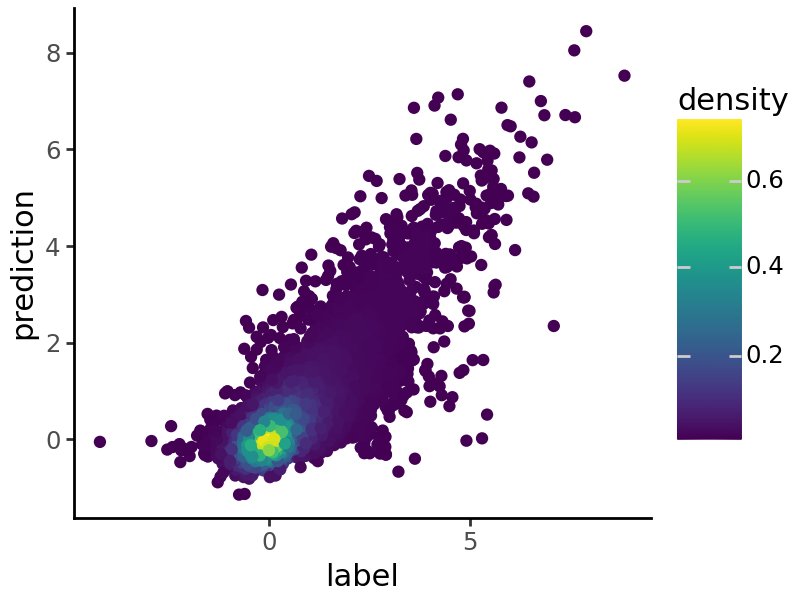

In [37]:
print(np.corrcoef(preds.reshape(-1), test_dataset.labels.reshape(-1))[0][1])
plot_pred_scatter(preds, test_dataset.labels, tasks=[0],  density = True) # k562